[*********************100%***********************]  1 of 1 completed


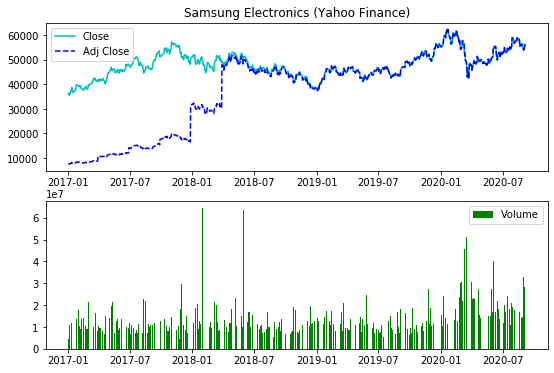

In [1]:
# 데이터 분석을 위해선 OHLC 데이터가 필요, 야후 API는 국내 데이터에 오류가 많아서 실제 트레이딩에는 부적합
# 정확한 데이터를 확보하려면 네이버 금융 스크레이핑, 문제는 속도가 느림 -> 주기적으로 종목별 OHLC 데이터를 스크레이핑해서
# 데이터 베이스에 저장, 필요할 때마다 조회하는 방식이 효율적 -> 시세 조회 API를 직접 제작

#야후 파이낸스와 네이버 금융 비교하기
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
%matplotlib inline

df = pdr.get_data_yahoo('005930.KS', '2017-01-01')

plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.title('Samsung Electronics (Yahoo Finance)')
plt.plot(df.index, df['Close'], 'c', label = 'Close')
plt.plot(df.index, df['Adj Close'], 'b--', label = 'Adj Close')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.bar(df.index, df['Volume'], color='g', label = 'Volume')
plt.legend(loc='best')
plt.show()
# 그림을 보면 종가/수정종가가 정확하지 않음, 자료가 빈 부분이 존재

In [2]:
# 네이버 금융 데이터로 시세 데이터베이스 구축하기
# 마리아디비설치(www.mariadb.com)
# cmd 창에서 마리아디비 설치경로 bin 폴더에 있는 mysql.exe 실행 ; 이 때 mysql.exe -u root -p로 실행
# CREATE DATABASE 데이터베이스이름; ->데이터베이스 생성
# SHOW DATABASES; -> 데이터베이스를 보여줌
# USE 데이터베이스이름; -> 데이터베이스 사용
# SHOW TABLES; -> 데이터베이스에 존재하는 테이블 확인
# SELECT VERSION(); -> 버전 확인
# DROP DATABASE 데이터베이스이름; -> 데이터베이스 삭제

# 위의 과정은 CLI 기반이지만 똑같은 과정을 GUI 기반의 헤이디에스큐엘로도 수행 가능; 헤이디에스큐엘 위치는 C:\Program Files (x86)\Common Files\MariaDBShared\HeidiSQL
#신규버튼을 입력해서 신규 세션 생성 & 패스워드 치고 접속 -> 세션 우클릭 - 새로 생성 - 데이터베이스로 새로운 데이터 베이스를 만든 후 인코딩 방식 utf8-general-ci로 설정

#파이마이에스큐엘로 버전 정보 확인하기
#파이썬 프로그램 내부에서 마리아디비를 사용하려면 파이마이에스큐엘 라이브러리 필요 : pip install pymysql

import pymysql

In [3]:
#SELECT 쿼리문으로 마리아디비 버전 정보 확인해보기

#데이터베이스에서 변경된 내역을 영구적으로 확정하는 것을 커밋commit이라고 함
#파이마이에스큐엘의 connection 객체의 autocommit 속성은 기본적으로 False이기 때문에 INSERT, UPDATE, DELETE 문으로 데이터를 변경하더라도 connection.commit()함수를 호출해야 실제 데이터베이스에 반영

connection = pymysql.connect(host = 'localhost', port = 3306, db = 'INVESTAR', user = 'root', passwd = 'qwe0611', autocommit = True)
#connect() 함수를 이용해 connection 객체 생성
# autocommit = True로 하면 SQL의 결과가 자동으로 데이터베이스에 반영

cursor = connection.cursor() # cursor()함수를 사용해 cursor 객체 생성
cursor.execute('SELECT VERSION();') #execute()함수를 통해 SELECT문 실행
result = cursor.fetchone() #fetchone() 함수를 통해 실행 결과를 튜플로 받기

print("MariaDB version : {}".format(result))

connection.close()

MariaDB version : ('10.5.5-MariaDB',)


In [4]:
#주식 시세를 매일 DB로 업데이트 하기
#네이버금융의 주식 시세를 뷰티풀 수프와 팬더스로 읽어와서 마리아디비에 매일 자동으로 업데이트해주는 DBUpadater 모듈 만들기

#DBUpdater 클래스 구조
#C:\mypackage 디렉터리를 만들고 그 안에 Investar 패키지를 생성할 Investar 디렉터리 만들기
#그 다음에 다음과 같은 DBUpater.py 생성


#DBUpdater.py의 스텁코드(뼈대)
class DBUpater:
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
    def __del__(self):
        """소멸자:MariaDB 연결해제"""
    def read_krx_code(self):
        """KRX로부터 상장법인목록 파일을 읽어와서 데이터프레임으로 반환"""
    def update_comp_info(self):
        """종목코드를 company_info 테이블에 업데이트한 후 딕셔너리에 저장"""
    def read_naver(self, code, company, pages_to_fetch):
        """네이버 금융에서 주식 시세를 읽어서 데이터프레임으로 반환"""
    def replace_into_db(self, df, num, code, company):
        """네이버 금융에서 읽어온 주식 시세를 DB에 REPLACE"""
    def update_daily_price(self, pages_to_fetch):
        """KRX 상장법인의 주식 시세를 네이버로부터 읽어서 DB에 업데이트"""
    def execute_daily(self):
        """실행 즉시 매일 오후 다섯시에 daily_price 테이블 업데이트"""
if __name__=='__main__':
    dbu = DBUpdater()
    dbu.execute_daily()


NameError: name 'DBUpdater' is not defined

In [1]:
#헤이디에스큐엘로 테이블 생성하기
# 여기에 나오는 복합키, 테이블, 쿼리 등의 개념은 컴활 때 배웠던 개념과 완전히 같음
#Investar 데이터베이스에 회사명과 종목코드를 저장할 company_info 테이블과 주식 시세를 저장할 daily_price 테이블 생성 -> 마리아디비에서 직접 작성
# CREATE TABLE IF NOT EXISTS company_info (
# 	code VARCHAR(20),
# 	company VARCHAR(40),
# 	last_update DATE,
# 	PRIMARY KEY (code)
# );

# CREATE TABLE IF NOT EXISTS daily_price (
# 	code VARCHAR(20),
# 	date DATE,
# 	open BIGINT(20),
# 	high BIGINT(20),
# 	low BIGINT(20),
# 	close BIGINT(20),
# 	diff BIGINT(20),
# 	volume BIGINT(20),
# 	PRIMARY KEY (code, date)
# );

# 파이마이에스큐엘로 테이블 생성하기
# 파이마이에스큐엘 라이브러리를 이용하여 파이썬 프로그램에서 직접 SQL 구문 실행 가능

import pymysql
import pandas as pd
from urllib.request import urlopen
from datetime import datetime
from bs4 import BeautifulSoup
from threading import Timer
import urllib, pymysql, calendar, time, json

class DBUpdater: #DBUpdater 클래스는 객체가 생성될 때 마리아디비에 접속하고, 소멸될 때 접속을 해제
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
        self.conn = pymysql.connect(host = 'localhost', user = 'root', password = 'qwe0611', db='Investar', charset='utf8') #일반적으로 한글을 이용하면 오류가 발생하므로, 반드시 utf8로 인코딩 형식 지정
        
        with self.conn.cursor() as curs: #이미 존재하는 테이블에 CREATE TABLE 구문을 추가하면 오류가 발생하므로 IF NOT EXIST 구문을 이용하는 것
            sql = """
            CREATE TABLE IF NOT EXISTS company_info ( 
                code VARCHAR(20),
                company VARCHAR(40),
                last_update DATE,
                PRIMARY KEY (code))
            """
            curs.execute(sql)
            sql = """
            CREATE TABLE IF NOT EXISTS daily_price (
                code VARCHAR(20),
                date DATE,
                open BIGINT(20),
                high BIGINT(20),
                low BIGINT(20),
                close BIGINT(20),
                diff BIGINT(20),
                volume BIGINT(20),
                PRIMARY KEY (code, date))
            """
            curs.execute(sql)
        self.conn.commit()
        self.codes = dict()
        self.update_comp_info()
        
    def __del__(self):
        """소멸자:MariaDB 연결해제"""
        self.conn.close()
        
    def read_krx_code(self):
        """KRX로부터 상장법인목록 파일을 읽어와서 데이터프레임으로 반환"""
        url = 'https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'
        krx = pd.read_html(url, header=0)[0]
        krx = krx[['종목코드', '회사명']]
        krx = krx.rename(columns={'종목코드':'code', '회사명' : 'company'})
        krx.code = krx.code.map('{:06d}'.format)
        return krx
    
    def update_comp_info(self):
        """종목코드를 company_info 테이블에 업데이트한 후 딕셔너리에 저장"""
        sql = "SELECT * FROM company_info"
        df = pd.read_sql(sql, self.conn) # company_info 테이블을 read_sql()함수로 읽는다
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]] = df['company'].values[idx] # read_sql()로 읽은 데이터프레임을 이용, codes딕셔너리 생성
        with self.conn.cursor() as curs:
            sql = "SELECT max(last_update) FROM company_info" #가장 최근의 날짜 가져오기
            curs.execute(sql)
            rs = curs.fetchone()
            today = datetime.today().strftime('%Y-%m-%d') #strftime은 datetime의 형식을 지정
            
            if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today: #하루에 한번씩 업데이트
                krx = self.read_krx_code()
                for idx in range(len(krx)):
                    code = krx.code.values[idx]
                    company = krx.company.values[idx]
                    sql = f"REPLACE INTO company_info (code, company, last_update) VALUES ('{code}', '{company}', '{today}')"
                    #REPLACE문은 표준 SQL은 아니지만 마리아디비에서 제공되는 SQL문으로 데이터 행이 테이블에 이미 존재했을 때 오류가 나는 INSERT 문의 단점을 보완
                    curs.execute(sql)
                    self.codes[code] = company
                    tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                    print(f"[{tmnow}] {idx:04d} REPLACE INTO company_info VALUES ({code}, {company}, {today})")
                self.conn.commit()
            
                    
        
    def read_naver(self, code, company, pages_to_fetch):
        """네이버 금융에서 주식 시세를 읽어서 데이터프레임으로 반환"""
        try:
            url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
            with urlopen(url) as doc:
                if doc is None:
                    return None
                html = BeautifulSoup(doc,'lxml')
                pgrr = html.find("td", class_ = "pgRR")
                if pgrr is None:
                    return None
                s = str(pgrr.a["href"]).split('=')
                lastpage = s[-1]
            df = pd.DataFrame()
            pages = min(int(lastpage), pages_to_fetch)
            for page in range(1, pages + 1):
                pg_url = '{}&page={}'.format(url,page)
                df = df.append(pd.read_html(pg_url, header = 0)[0])
                tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                print('[{}] {} ({}) : {:04d}/{:04d} pages are downloading...'.format(tmnow, company, code, page, pages), end= "\r")
            df = df.rename(columns = {'날짜' : 'date', '종가' : 'close', '전일비' : 'diff', '시가' : 'open', '고가' : 'high', '저가' : 'low', '거래량' : 'volume'})
            df['date'] = df['date'].replace('.','-')
            df = df.dropna()
            df[['close','diff','open','high','low','volume']] = df[['close','diff','open','high','low','volume']].astype(int)
            df = df[['date','open','high','low','close','diff','volume']]
        except Exception as e:
            print('Exception occured :', str(e))
            return None
        return df
    def replace_into_db(self, df, num, code, company):
        """네이버 금융에서 읽어온 주식 시세를 DB에 REPLACE"""
        with self.conn.cursor() as curs:
            for r in df.itertuples():
                sql = f"REPLACE INTO daily_price VALUES ('{code}', '{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, {r.diff}, {r.volume})"
                curs.execute(sql)
            self.conn.commit()
            print("[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_price[OK]".format(datetime.now().strftime('%Y-%m-%d %H:%M'), num+1, company, code, len(df)))
        
    def update_daily_price(self, pages_to_fetch):
        """KRX 상장법인의 주식 시세를 네이버로부터 읽어서 DB에 업데이트"""
        for idx, code in enumerate(self.codes):
            df = self.read_naver(code, self.codes[code], pages_to_fetch)
            if df is None:
                continue
            self.replace_into_db(df, idx, code, self.codes[code])
            
    def execute_daily(self):
        """실행 즉시 매일 오후 다섯시에 daily_price 테이블 업데이트"""
        self.update_comp_info()
        try:
            with open('config.json', 'r') as in_file:
                config = json.load(in_file)
                pages_to_fetch = config['pages_to_fetch']
        except FileNotFoundError:
            with open('config.json', 'w') as out_file:
                pages_to_fetch = 100
                config = {'pages_to_fetch' : 1}
                json.dump(config, out_file)
        self.update_daily_price(pages_to_fetch)
        
        tmnow = datetime.now()
        lastday = calendar.monthrange(tmnow.year, tmnow.month)[1]
        if tmnow.month == 12 and tmnow.day == lastday:
            tmnext = tmnow.replace(year = tmnow.year+1, month=1, day=1, hour = 17, minute = 0, second = 0)
        elif tmnow.day == lastday:
            tmnext = tmnow.replace(month=tmnow.month+1, day=1, hour = 17, minute = 0, second = 0)
        else:
            tmnext = tmnow.replace(day=tmnow.day+1, hour = 17, minute=0, second = 0)
        tmdiff = tmnext - tmnow
        secs = tmdiff.seconds
        
        t = Timer(secs, self.execute_daily)
        print("Waiting for next update ({}) ...".format(tmnext.strftime('%Y-%m-%d %H:%M')))
        t.start()
if __name__=='__main__':
    dbu = DBUpdater()
    dbu.execute_daily()


[2020-09-07 23:27] 0000 REPLACE INTO company_info VALUES (155660, DSR, 2020-09-07)
[2020-09-07 23:27] 0001 REPLACE INTO company_info VALUES (078930, GS, 2020-09-07)


DataError: (1366, "Incorrect string value: '\\xEA\\xB8\\x80\\xEB\\xA1\\x9C...' for column `investar`.`company_info`.`company` at row 1")

In [11]:
from datetime import datetime

a = datetime.today().strftime('%Y-%m-%d')
a

'2020-09-05'

In [11]:
import pandas as pd
krxlist = pd.read_excel('krx_list_500.xlsx')
krxlist

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,미래에셋대우스팩 5호,353490,금융 지원 서비스업,금융 지원 서비스업,2020-08-28,12월,김영도,NaN,서울특별시
1,미투젠,950190,소프트웨어 개발 및 공급업,"캐주얼게임, 소셜카지노게임",2020-08-18,12월,린즈웨이/라우호밍,http://www.me2zen.com,홍콩
2,제이알글로벌리츠,348950,부동산 임대 및 공급업,벨기에 파이낸스 타워,2020-08-07,01월,오남수,http://jrglobalreit.com,서울특별시
3,솔브레인,357780,기타 화학제품 제조업,반도체 및 디스플레이 관련 화학재료 제조ㆍ판매 등,2020-08-06,12월,강병창,http://www.soulbrain.co.kr,경기도
4,와이팜,332570,전자부품 제조업,전력증폭기 모듈(PAM),2020-07-31,12월,유대규,http://www.wipam.co.kr,경기도
...,...,...,...,...,...,...,...,...,...
514,대한항공,3490,항공 여객 운송업,"여객운송,화물운송,항공기 제조,판매,정비수리/기내식 제조판매,면세품 판매",1966-03-18,12월,"조원태, 우기홍",http://www.koreanair.com,서울특별시
515,유한양행,100,의약품 제조업,"의약품(삐콤씨,알마겔,세파졸린주사,아코텍스주사,이세파신,신생아호흡곤란치료제 등),생...",1962-11-01,12월,대표이사 이정희,http://www.yuhan.co.kr,서울특별시
516,CJ대한통운,120,도로 화물 운송업,"Contract Logistics, 포워딩, 항만하역, 해운, 택배국제특송, SCM...",1956-07-02,12월,박근희,http://www.cjlogistics.com,서울특별시
517,메리츠화재,60,보험업,"손해보험(화재,해상,운송보험)",1956-07-02,12월,김용범,http://www.meritzfire.com,서울특별시


In [16]:
abc = krxlist[['회사명','종목코드']]
abc

,회사명,종목코드
0,미래에셋대우스팩 5호,353490
1,미투젠,950190
2,제이알글로벌리츠,348950
3,솔브레인,357780
4,와이팜,332570
...,...,...
514,대한항공,3490
515,유한양행,100
516,CJ대한통운,120
517,메리츠화재,60


In [ ]:
#일별 시세 조회 API --> Analyzer 노트북에 따로 작성